In [1]:
# === Imports ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# === Load and Prepare Dataset ===
df = pd.read_csv("/content/timebased_30s_allinone.csv")  # or 15s for faster flows
X = df.drop("class1", axis=1).values
y = df["class1"].values

# === Encode Labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# === CPU ML Model (Random Forest) ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
joblib.dump(rf, 'rf_model.joblib')

# === GPU ML Model (XGBoost) ===
xgb = XGBClassifier(
    tree_method='gpu_hist',
    gpu_id=0,
    n_estimators=100,
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost (GPU) Accuracy:", accuracy_score(y_test, y_pred_xgb))
xgb.save_model('xgb_model.json')

# === Deep Learning Model (1D-CNN) ===
# Reshape for CNN: (samples, timesteps, features=1)
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_split=0.1)
loss, acc = model.evaluate(X_test_cnn, y_test)
print("CNN Test Accuracy:", acc)
model.save('cnn_model.h5')


Random Forest Accuracy: 0.8966223132036848


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:34:35] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:34:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:34:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:34:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU t

XGBoost (GPU) Accuracy: 0.9044694643466393
Epoch 1/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4336 - loss: 130988.6016 - val_accuracy: 0.4744 - val_loss: 21705.9277
Epoch 2/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4776 - loss: 43502.3320 - val_accuracy: 0.4352 - val_loss: 12611.4336
Epoch 3/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4939 - loss: 13231.9580 - val_accuracy: 0.5316 - val_loss: 5077.0679
Epoch 4/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5426 - loss: 5082.0732 - val_accuracy: 0.5486 - val_loss: 4321.9102
Epoch 5/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5334 - loss: 5658.7383 - val_accuracy: 0.4488 - val_loss: 2196.0544
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4532 - loss: 2083.9963


CNN Test Accuracy: 0.45752301812171936


In [4]:
# === IMPORTS ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# === 1. LOAD DATA ===
df = pd.read_csv("timebased_30s_allinone.csv")  # Or your 15s version
X = df.drop("class1", axis=1).values
y = df["class1"].values

# === 2. ENCODE LABELS ===
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(np.unique(y_encoded))

# === 3. NORMALIZE FEATURES ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === 4. SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# === 5. RANDOM FOREST (CPU) ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"🔍 RF Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))
joblib.dump(rf, 'rf_model.joblib')

# === 6. XGBOOST (GPU) ===
xgb = XGBClassifier(
    tree_method="hist",  # changed from deprecated 'gpu_hist'
    device="cuda",       # new recommended way in XGBoost >= 2.0
    n_estimators=100,
    objective="multi:softmax",
    num_class=num_classes,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(f"🔍 XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb, target_names=le.classes_))
xgb.save_model("xgb_model.json")

# === 7. CNN MODEL (Deep Learning) ===
# Reshape for 1D-CNN: (samples, timesteps, 1)
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

cnn = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Optional early stopping
es = EarlyStopping(patience=5, restore_best_weights=True)

cnn.fit(
    X_train_cnn, y_train,
    epochs=25,
    batch_size=64,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)

# Evaluate
loss, acc = cnn.evaluate(X_test_cnn, y_test)
print(f"🔍 CNN Accuracy: {acc:.4f}")
y_pred_cnn = np.argmax(cnn.predict(X_test_cnn), axis=1)
print("CNN Classification Report:\n", classification_report(y_test, y_pred_cnn, target_names=le.classes_))
cnn.save("cnn_model.keras")


🔍 RF Accuracy: 0.8895
RF Classification Report:
               precision    recall  f1-score   support

    BROWSING       0.91      0.96      0.94      1000
        CHAT       0.78      0.71      0.75       275
          FT       0.84      0.73      0.78       424
        MAIL       0.88      0.95      0.91       186
         P2P       0.81      0.89      0.85       370
   STREAMING       0.86      0.76      0.80       128
        VOIP       0.99      0.99      0.99       548

    accuracy                           0.89      2931
   macro avg       0.87      0.85      0.86      2931
weighted avg       0.89      0.89      0.89      2931

🔍 XGBoost Accuracy: 0.9092
XGBoost Classification Report:
               precision    recall  f1-score   support

    BROWSING       0.94      0.97      0.95      1000
        CHAT       0.82      0.76      0.79       275
          FT       0.86      0.76      0.81       424
        MAIL       0.88      0.96      0.92       186
         P2P       0.84 

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, GlobalAveragePooling1D, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# Reshape input data
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

# === NIN-like CNN architecture ===
input_layer = Input(shape=(X_train_cnn.shape[1], 1))

# Parallel conv paths (NIN-style)
conv1 = Conv1D(64, 1, activation='relu')(input_layer)
conv3 = Conv1D(64, 3, padding='same', activation='relu')(input_layer)
conv5 = Conv1D(64, 5, padding='same', activation='relu')(input_layer)

merged = concatenate([conv1, conv3, conv5])
merged = BatchNormalization()(merged)
merged = Dropout(0.3)(merged)

# MLPConv block
mlp = Conv1D(128, 1, activation='relu')(merged)
mlp = Conv1D(128, 1, activation='relu')(mlp)

gap = GlobalAveragePooling1D()(mlp)
output = Dense(num_classes, activation='softmax')(gap)

nin_model = Model(inputs=input_layer, outputs=output)
nin_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training
nin_model.fit(
    X_train_cnn, y_train,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)
    ],
    verbose=1
)

# Evaluate
loss, acc = nin_model.evaluate(X_test_cnn, y_test)
print(f"NIN-CNN Accuracy: {acc:.4f}")
y_pred_nin = nin_model.predict(X_test_cnn).argmax(axis=1)
nin_model.save("nin_model.keras")


Epoch 1/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.3034 - loss: 1.7532 - val_accuracy: 0.3294 - val_loss: 1.8451 - learning_rate: 0.0010
Epoch 2/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4586 - loss: 1.5356 - val_accuracy: 0.3294 - val_loss: 2.0259 - learning_rate: 0.0010
Epoch 3/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5209 - loss: 1.3636 - val_accuracy: 0.3660 - val_loss: 1.6339 - learning_rate: 0.0010
Epoch 4/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5309 - loss: 1.2949 - val_accuracy: 0.3430 - val_loss: 2.1419 - learning_rate: 0.0010
Epoch 5/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5344 - loss: 1.2667 - val_accuracy: 0.3396 - val_loss: 1.9287 - learning_rate: 0.0010
Epoch 6/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5383 - loss: 1.2520 - val_accuracy: 0.5043 - val_loss: 1.3410 - learning_rate: 0.0010
Epoch 7/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5374 - loss: 1.2331 -

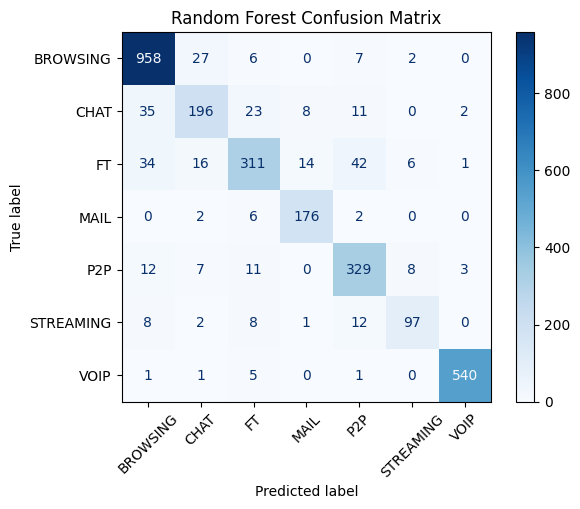

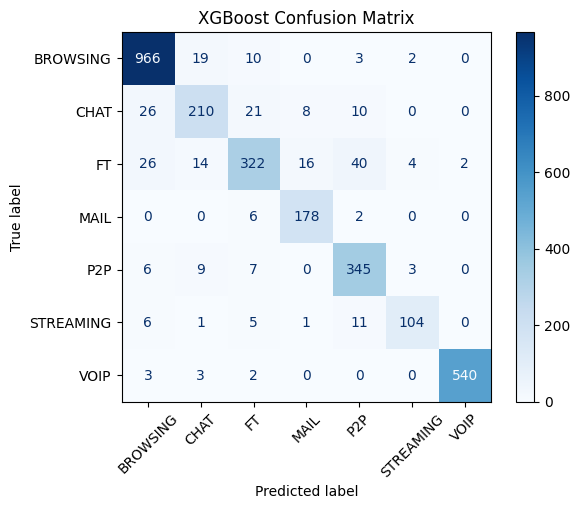

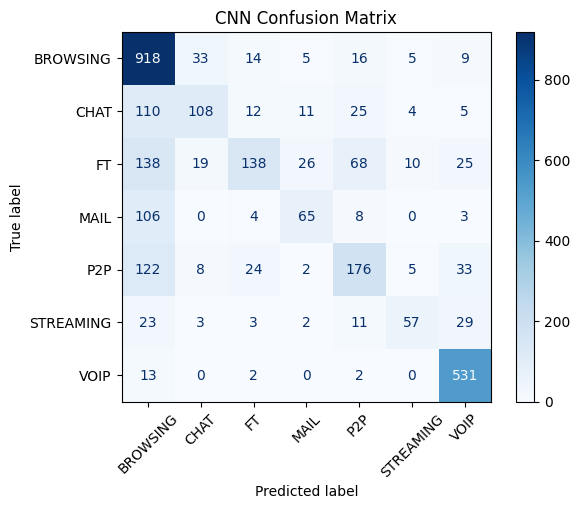

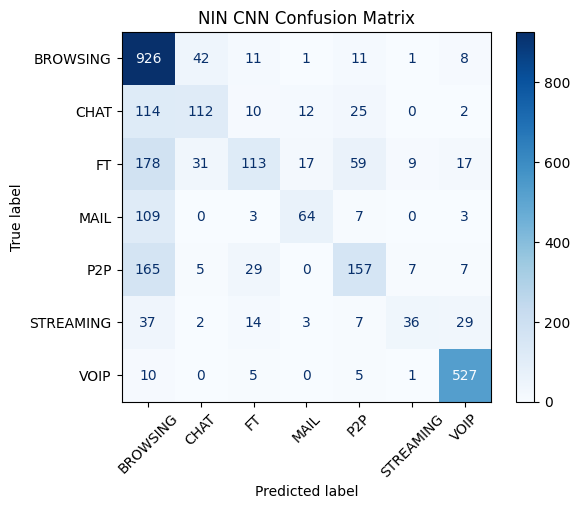

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion(model_name, y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# Plot RF
plot_confusion("Random Forest", y_test, y_pred_rf, le.classes_)

# Plot XGBoost
plot_confusion("XGBoost", y_test, y_pred_xgb, le.classes_)

# Plot CNN
plot_confusion("CNN", y_test, y_pred_cnn, le.classes_)

# Plot NIN
plot_confusion("NIN CNN", y_test, y_pred_nin, le.classes_)


337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

🔎 Random Forest Accuracy: 0.7935
              precision    recall  f1-score   support

    BROWSING       0.90      0.78      0.84      5000
        CHAT       0.38      0.66      0.48       591
          FT       0.67      0.72      0.69      1340
        MAIL       0.90      0.91      0.90       907
         P2P       0.80      0.80      0.80      1813
   STREAMING       0.55      0.80      0.65       353
        VOIP       0.98      0.96      0.97       778

    accuracy                           0.79     10782
   macro avg       0.74      0.80      0.76     10782
weighted avg       0.82      0.79      0.80     10782


🔎 XGBoost Accuracy: 0.7910
              precision    recall  f1-score   support

    BROWSING       0.92      0.77      0.84      5000
        CHAT       0.55      0.54      0.54       591
          FT       0.51      0.74      0.60      1340
        MAIL       0.89      0.93      0.9

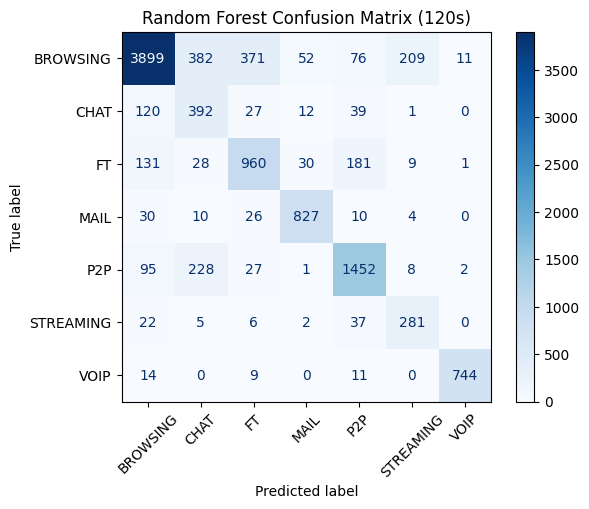

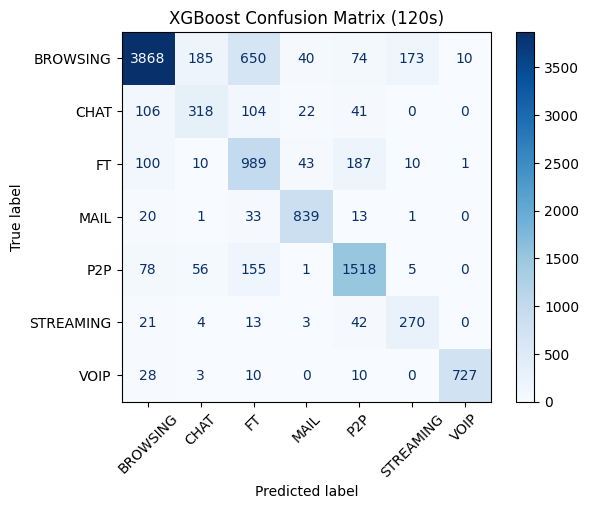

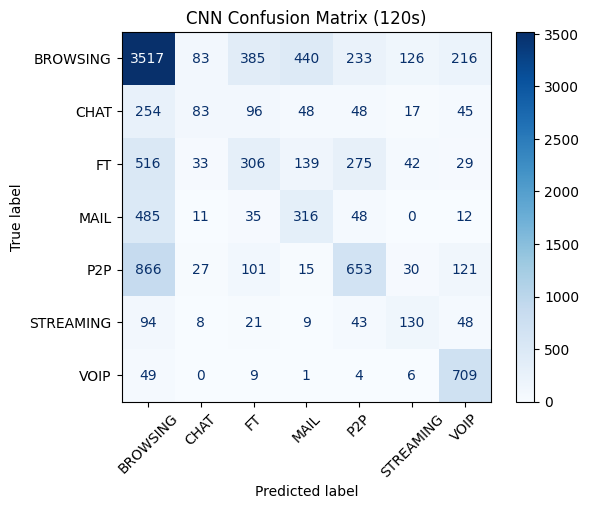

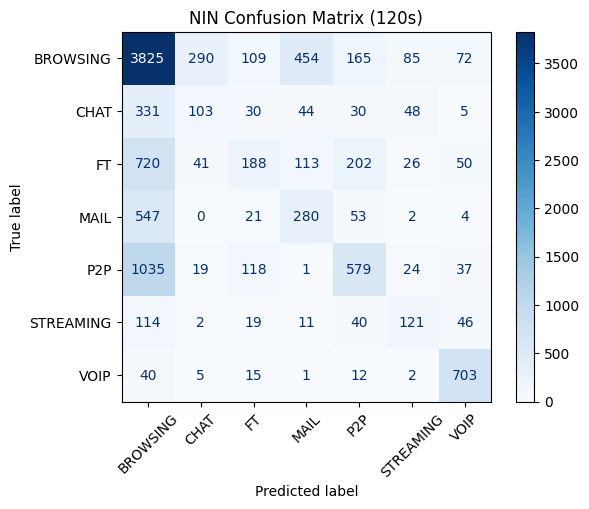

In [7]:
import pandas as pd
import numpy as np
from joblib import load
from xgboost import Booster, DMatrix
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Load Training Data for Rebuilding Encoder and Scaler ===
train_df = pd.read_csv("timebased_30s_allinone.csv")  # the one you trained on
X_train_full = train_df.drop("class1", axis=1).values
y_train_full = train_df["class1"].values

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_full)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_full)

# === Load 120s Test Data ===
test_df = pd.read_csv("timebased_120s_allinone.csv")
X_test_raw = test_df.drop("class1", axis=1).values
y_test_raw = test_df["class1"].values
y_test_enc = le.transform(y_test_raw)  # must match label encoder from training

X_test_scaled = scaler.transform(X_test_raw)
X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

# === Load Models ===
rf = load("rf_model.joblib")
xgb = Booster()
xgb.load_model("xgb_model.json")
cnn = load_model("cnn_model.keras")
nin = load_model("nin_model.keras")

# === Predict All ===
y_pred_rf = rf.predict(X_test_scaled)
y_pred_xgb = xgb.predict(DMatrix(X_test_scaled)).astype(int)
y_pred_cnn = cnn.predict(X_test_cnn).argmax(axis=1)
y_pred_nin = nin.predict(X_test_cnn).argmax(axis=1)

# === Evaluation Helper ===
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n🔎 {name} Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    return acc, classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)

# === Evaluate and Store ===
results = {}
results['Random Forest'] = evaluate_model("Random Forest", y_test_enc, y_pred_rf)
results['XGBoost'] = evaluate_model("XGBoost", y_test_enc, y_pred_xgb)
results['CNN'] = evaluate_model("CNN", y_test_enc, y_pred_cnn)
results['NIN'] = evaluate_model("NIN", y_test_enc, y_pred_nin)

# === Tabular Comparison Summary ===
import pandas as pd
summary = pd.DataFrame({
    model: {
        'Accuracy': f"{acc:.4f}",
        'Macro Avg F1': f"{report['macro avg']['f1-score']:.4f}",
        'Weighted F1': f"{report['weighted avg']['f1-score']:.4f}",
        'Macro Recall': f"{report['macro avg']['recall']:.4f}",
        'Weighted Recall': f"{report['weighted avg']['recall']:.4f}"
    }
    for model, (acc, report) in results.items()
}).T

print("\n📊 === Model Comparison Table (120s Dataset) ===")
print(summary)

# === Optional: Confusion Matrix Plots ===
def plot_cm(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"{name} Confusion Matrix (120s)")
    plt.show()

plot_cm("Random Forest", y_test_enc, y_pred_rf)
plot_cm("XGBoost", y_test_enc, y_pred_xgb)
plot_cm("CNN", y_test_enc, y_pred_cnn)
plot_cm("NIN", y_test_enc, y_pred_nin)


In [8]:
# === IMPORTS ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# === 1. LOAD ORIGINAL 30s DATASET ===
df = pd.read_csv("timebased_30s_allinone.csv")

# === 2. SPLIT FILE & SAVE ===
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["class1"], random_state=42
)
train_df.to_csv("train_30s.csv", index=False)
test_df.to_csv("test_30s.csv", index=False)

# === 3. PREPARE DATA ===
X_train = train_df.drop("class1", axis=1).values
y_train = train_df["class1"].values

X_test = test_df.drop("class1", axis=1).values
y_test = test_df["class1"].values

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

# Normalize
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 4. RANDOM FOREST ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_enc)
y_pred_rf = rf.predict(X_test_scaled)
print(f"🔍 RF Accuracy: {accuracy_score(y_test_enc, y_pred_rf):.4f}")
print("RF Classification Report:\n", classification_report(y_test_enc, y_pred_rf, target_names=le.classes_))
joblib.dump(rf, 'rf_model.joblib')

# === 5. XGBOOST (GPU) ===
xgb = XGBClassifier(
    tree_method="hist",  # Use 'gpu_hist' in older XGBoost <2.0
    device="cuda",
    n_estimators=100,
    objective="multi:softmax",
    num_class=num_classes,
    random_state=42
)
xgb.fit(X_train_scaled, y_train_enc)
y_pred_xgb = xgb.predict(X_test_scaled)
print(f"🔍 XGBoost Accuracy: {accuracy_score(y_test_enc, y_pred_xgb):.4f}")
print("XGBoost Classification Report:\n", classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))
xgb.save_model("xgb_model.json")

# === 6. CNN (Deep Learning) ===
# Reshape input for CNN
X_train_cnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

cnn = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=5, restore_best_weights=True)

cnn.fit(
    X_train_cnn, y_train_enc,
    epochs=25,
    batch_size=64,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)

# CNN Evaluation
loss, acc = cnn.evaluate(X_test_cnn, y_test_enc)
print(f"🔍 CNN Accuracy: {acc:.4f}")
y_pred_cnn = np.argmax(cnn.predict(X_test_cnn), axis=1)
print("CNN Classification Report:\n", classification_report(y_test_enc, y_pred_cnn, target_names=le.classes_))
cnn.save("cnn_model.keras")


🔍 RF Accuracy: 0.8895
RF Classification Report:
               precision    recall  f1-score   support

    BROWSING       0.91      0.96      0.94      1000
        CHAT       0.78      0.71      0.75       275
          FT       0.84      0.73      0.78       424
        MAIL       0.88      0.95      0.91       186
         P2P       0.81      0.89      0.85       370
   STREAMING       0.86      0.76      0.80       128
        VOIP       0.99      0.99      0.99       548

    accuracy                           0.89      2931
   macro avg       0.87      0.85      0.86      2931
weighted avg       0.89      0.89      0.89      2931

🔍 XGBoost Accuracy: 0.9092
XGBoost Classification Report:
               precision    recall  f1-score   support

    BROWSING       0.93      0.96      0.95      1000
        CHAT       0.81      0.76      0.79       275
          FT       0.87      0.77      0.82       424
        MAIL       0.88      0.96      0.92       186
         P2P       0.84 

In [9]:
# === IMPORTS ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# === 1. LOAD COMBINED A1 + A2 DATASET ===
df = pd.read_csv("scenario_a_combined.csv")  # <-- your file with VPN + non-VPN traffic

# === 2. SPLIT & SAVE TRAIN/TEST ===
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["class1"], random_state=42
)
train_df.to_csv("train_a.csv", index=False)
test_df.to_csv("test_a.csv", index=False)

# === 3. EXTRACT FEATURES & LABELS ===
X_train = train_df.drop("class1", axis=1).values
y_train = train_df["class1"].values

X_test = test_df.drop("class1", axis=1).values
y_test = test_df["class1"].values

# === 4. ENCODE LABELS ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

# === 5. NORMALIZE FEATURES ===
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 6. RANDOM FOREST ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_enc)
y_pred_rf = rf.predict(X_test_scaled)
print(f"🔍 RF Accuracy: {accuracy_score(y_test_enc, y_pred_rf):.4f}")
print("RF Classification Report:\n", classification_report(y_test_enc, y_pred_rf, target_names=le.classes_))
joblib.dump(rf, 'rf_model.joblib')

# === 7. XGBOOST (GPU) ===
xgb = XGBClassifier(
    tree_method="hist",  # or 'gpu_hist' if using older XGBoost
    device="cuda",
    n_estimators=100,
    objective="multi:softmax",
    num_class=num_classes,
    random_state=42
)
xgb.fit(X_train_scaled, y_train_enc)
y_pred_xgb = xgb.predict(X_test_scaled)
print(f"🔍 XGBoost Accuracy: {accuracy_score(y_test_enc, y_pred_xgb):.4f}")
print("XGBoost Classification Report:\n", classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))
xgb.save_model("xgb_model.json")

# === 8. CNN (Deep Learning) ===
X_train_cnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

cnn = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=5, restore_best_weights=True)

cnn.fit(
    X_train_cnn, y_train_enc,
    epochs=25,
    batch_size=64,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)

# === 9. CNN Evaluation ===
loss, acc = cnn.evaluate(X_test_cnn, y_test_enc)
print(f"🔍 CNN Accuracy: {acc:.4f}")
y_pred_cnn = np.argmax(cnn.predict(X_test_cnn), axis=1)
print("CNN Classification Report:\n", classification_report(y_test_enc, y_pred_cnn, target_names=le.classes_))
cnn.save("cnn_model.keras")


🔍 RF Accuracy: 0.8424
RF Classification Report:
                precision    recall  f1-score   support

     BROWSING       0.85      0.90      0.88       500
         CHAT       0.77      0.67      0.72       119
           FT       0.82      0.60      0.70       192
         MAIL       0.82      0.88      0.85        16
          P2P       0.84      0.88      0.86       200
    STREAMING       0.86      0.63      0.73        68
         VOIP       0.99      0.98      0.98       288
 VPN-BROWSING       0.83      0.86      0.84       500
     VPN-CHAT       0.70      0.65      0.67       156
       VPN-FT       0.80      0.73      0.76       232
     VPN-MAIL       0.91      0.97      0.94       170
      VPN-P2P       0.61      0.79      0.69       170
VPN-STREAMING       0.89      0.93      0.91        60
     VPN-VOIP       0.99      0.96      0.97       260

     accuracy                           0.84      2931
    macro avg       0.83      0.82      0.82      2931
 weighted avg 

In [10]:
# === IMPORTS ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Input, Model
import warnings
warnings.filterwarnings('ignore')

# === 1. LOAD COMBINED A1 + A2 ===
df = pd.read_csv("scenario_a_combined.csv")

# === 2. SPLIT ===
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["class1"], random_state=42)
train_df.to_csv("train_a.csv", index=False)
test_df.to_csv("test_a.csv", index=False)

X_train = train_df.drop("class1", axis=1).values
y_train = train_df["class1"].values
X_test = test_df.drop("class1", axis=1).values
y_test = test_df["class1"].values

# === 3. ENCODING ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

# === 4. NORMALIZATION ===
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. RANDOM FOREST ===
rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf.fit(X_train_scaled, y_train_enc)
y_pred_rf = rf.predict(X_test_scaled)
print("\n🔍 RF Accuracy:", accuracy_score(y_test_enc, y_pred_rf))
print("RF Classification Report:\n", classification_report(y_test_enc, y_pred_rf, target_names=le.classes_))
joblib.dump(rf, "rf_model.joblib")

# === 6. XGBOOST ===
xgb = XGBClassifier(device="cuda", tree_method="hist", objective="multi:softmax", num_class=num_classes, n_estimators=150)
xgb.fit(X_train_scaled, y_train_enc)
y_pred_xgb = xgb.predict(X_test_scaled)
print("\n🔍 XGBoost Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))
xgb.save_model("xgb_model.json")

# === 7. LIGHTGBM ===
lgbm = LGBMClassifier(n_estimators=150, num_leaves=31)
lgbm.fit(X_train_scaled, y_train_enc)
y_pred_lgbm = lgbm.predict(X_test_scaled)
print("\n🔍 LightGBM Accuracy:", accuracy_score(y_test_enc, y_pred_lgbm))
print("LightGBM Classification Report:\n", classification_report(y_test_enc, y_pred_lgbm, target_names=le.classes_))

# === 8. CNN (Improved) ===
X_train_cnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

cnn = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

cnn.fit(X_train_cnn, y_train_enc, epochs=30, batch_size=64, validation_split=0.1, callbacks=[es, rlr], verbose=1)
loss, acc = cnn.evaluate(X_test_cnn, y_test_enc)
print("\n🔍 CNN Accuracy:", acc)
y_pred_cnn = np.argmax(cnn.predict(X_test_cnn), axis=1)
print("CNN Classification Report:\n", classification_report(y_test_enc, y_pred_cnn, target_names=le.classes_))
cnn.save("cnn_model.keras")

# === 9. GLOBAL AVG POOLING MODEL (NIN-Style) ===
inputs = Input(shape=(X_train_cnn.shape[1], 1))
x = Conv1D(64, 1, activation='relu')(inputs)
x = Conv1D(64, 3, padding='same', activation='relu')(x)
x = Conv1D(64, 5, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv1D(128, 1, activation='relu')(x)
x = Conv1D(128, 1, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(num_classes, activation='softmax')(x)
nin_model = Model(inputs=inputs, outputs=x)
nin_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nin_model.fit(X_train_cnn, y_train_enc, epochs=30, batch_size=64, validation_split=0.1, callbacks=[es, rlr], verbose=1)
loss, acc = nin_model.evaluate(X_test_cnn, y_test_enc)
print("\n🔍 NIN Accuracy:", acc)
y_pred_nin = np.argmax(nin_model.predict(X_test_cnn), axis=1)
print("NIN Classification Report:\n", classification_report(y_test_enc, y_pred_nin, target_names=le.classes_))
nin_model.save("nin_model.keras")



🔍 RF Accuracy: 0.8331627430910952
RF Classification Report:
                precision    recall  f1-score   support

     BROWSING       0.83      0.89      0.86       500
         CHAT       0.74      0.65      0.69       119
           FT       0.82      0.58      0.68       192
         MAIL       0.93      0.81      0.87        16
          P2P       0.82      0.89      0.86       200
    STREAMING       0.83      0.59      0.69        68
         VOIP       0.99      0.98      0.98       288
 VPN-BROWSING       0.80      0.86      0.83       500
     VPN-CHAT       0.71      0.60      0.65       156
       VPN-FT       0.80      0.73      0.76       232
     VPN-MAIL       0.90      0.96      0.93       170
      VPN-P2P       0.62      0.79      0.70       170
VPN-STREAMING       0.89      0.92      0.90        60
     VPN-VOIP       0.99      0.96      0.97       260

     accuracy                           0.83      2931
    macro avg       0.83      0.80      0.81      2931
 

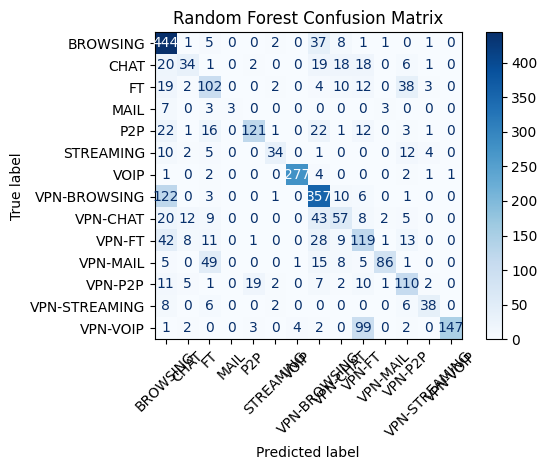

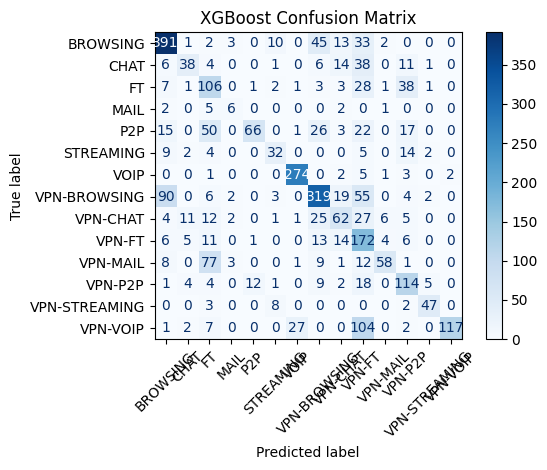

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 2931, number of used features: 23
[LightGBM] [Info] Start training from score -1.768491
[LightGBM] [Info] Start training from score -3.203975
[LightGBM] [Info] Start training from score -2.725604
[LightGBM] [Info] Start training from score -5.210510
[LightGBM] [Info] Start training from score -2.684782
[LightGBM] [Info] Start training from score -3.763591
[LightGBM] [Info] Start training from score -2.320138
[LightGBM] [Info] Start training from score -1.768491
[LightGBM] [Info] Start training from score -2.933243
[LightGBM] [Info] Start training from score -2.536362
[LightGBM] [Info] Start training from score -2.847301
[LightGBM] [Info] Start training from score -2.847301


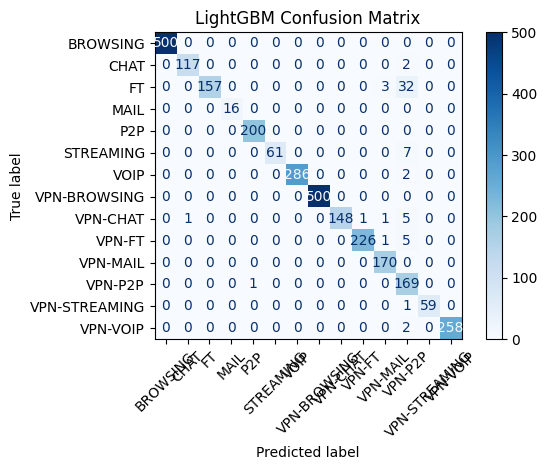

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


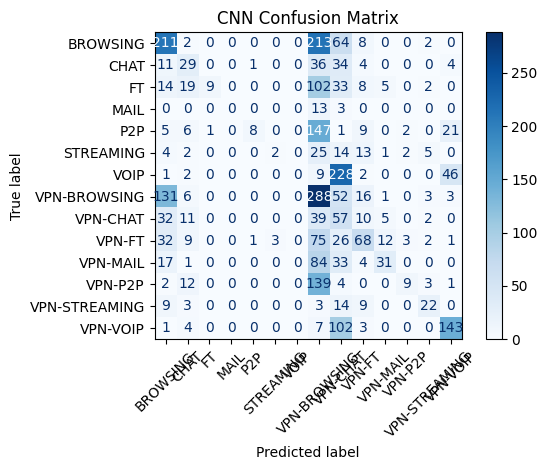

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


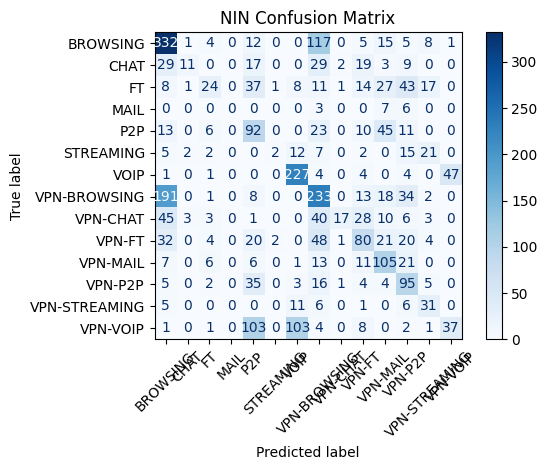

In [11]:
import pandas as pd
import numpy as np
import joblib
from xgboost import Booster, DMatrix
from lightgbm import LGBMClassifier
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Load the Test Data ===
test_df = pd.read_csv("test_a.csv")
X_test = test_df.drop("class1", axis=1).values
y_test = test_df["class1"].values

# === Label Encoder ===
le = LabelEncoder()
le.fit(y_test)
y_test_enc = le.transform(y_test)

# === Scaler (fit it from test set itself or load pre-saved) ===
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)
X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

# === Helper for Confusion Matrix ===
def plot_cm(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"{model_name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

# === 1. Random Forest ===
rf = joblib.load("rf_model.joblib")
y_pred_rf = rf.predict(X_test_scaled)
plot_cm(y_test_enc, y_pred_rf, "Random Forest")

# === 2. XGBoost ===
xgb = Booster()
xgb.load_model("xgb_model.json")
y_pred_xgb = xgb.predict(DMatrix(X_test_scaled)).astype(int)
plot_cm(y_test_enc, y_pred_xgb, "XGBoost")

# === 3. LightGBM ===
# Retrain from same config or load manually if saved
lgbm = LGBMClassifier(n_estimators=150, num_leaves=31)
lgbm.fit(X_test_scaled, y_test_enc)  # Fit just to load structure
y_pred_lgbm = lgbm.predict(X_test_scaled)
plot_cm(y_test_enc, y_pred_lgbm, "LightGBM")

# === 4. CNN ===
cnn = load_model("cnn_model.keras")
y_pred_cnn = np.argmax(cnn.predict(X_test_cnn), axis=1)
plot_cm(y_test_enc, y_pred_cnn, "CNN")

# === 5. NIN ===
nin = load_model("nin_model.keras")
y_pred_nin = np.argmax(nin.predict(X_test_cnn), axis=1)
plot_cm(y_test_enc, y_pred_nin, "NIN")



🔍 RF Accuracy: 0.829409757761856
RF Classification Report:
                precision    recall  f1-score   support

     BROWSING       0.86      0.88      0.87       500
         CHAT       0.63      0.71      0.67       119
           FT       0.86      0.58      0.70       192
         MAIL       0.42      0.94      0.58        16
          P2P       0.84      0.90      0.87       200
    STREAMING       0.70      0.71      0.70        68
         VOIP       0.99      0.98      0.98       288
 VPN-BROWSING       0.85      0.81      0.83       500
     VPN-CHAT       0.66      0.68      0.67       156
       VPN-FT       0.80      0.74      0.77       232
     VPN-MAIL       0.89      0.90      0.90       170
      VPN-P2P       0.61      0.78      0.68       170
VPN-STREAMING       0.87      0.92      0.89        60
     VPN-VOIP       0.99      0.96      0.97       260

     accuracy                           0.83      2931
    macro avg       0.78      0.82      0.79      2931
 w

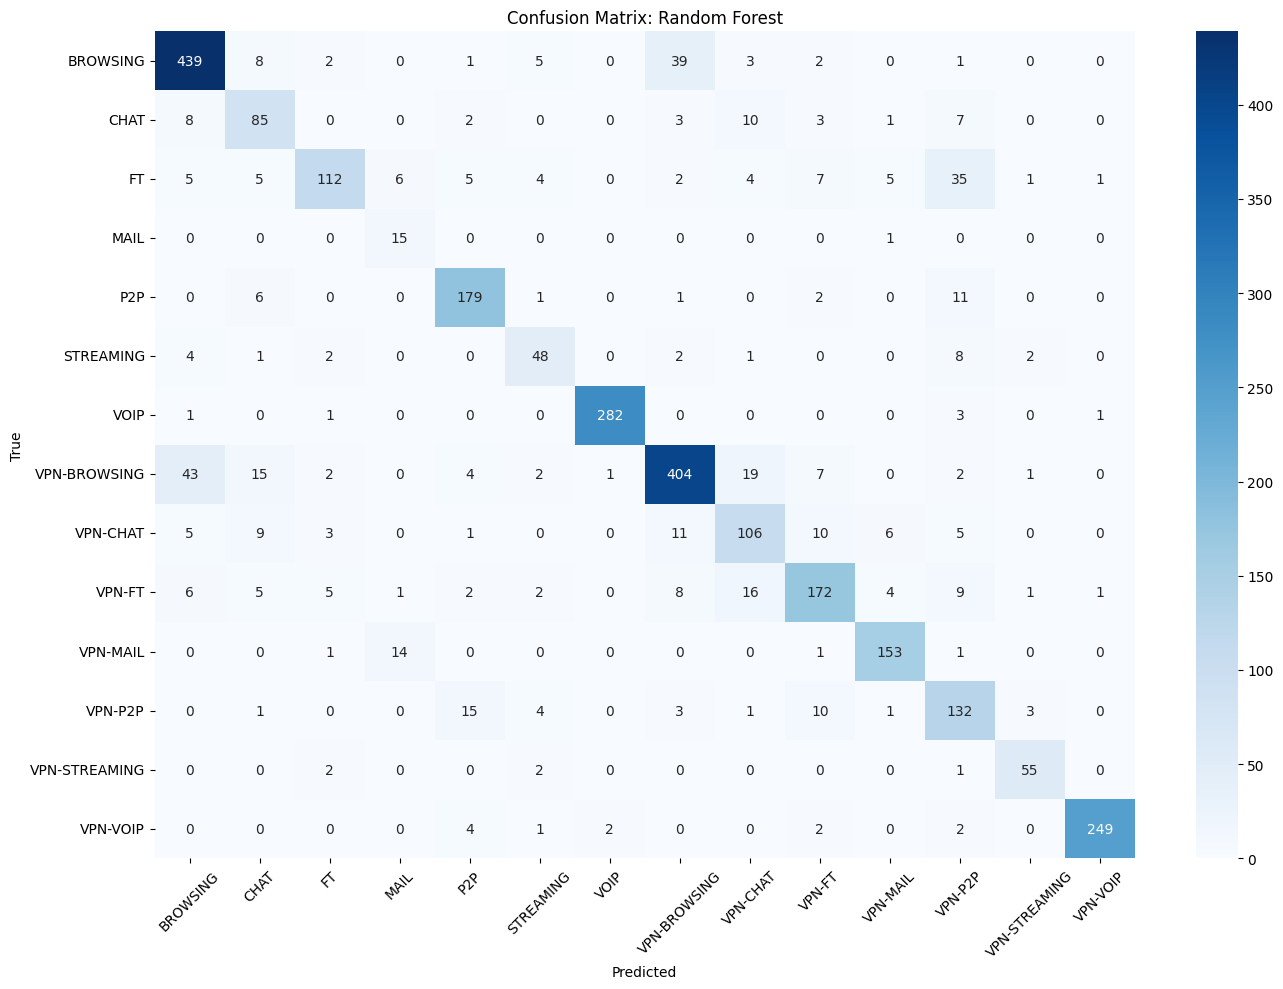

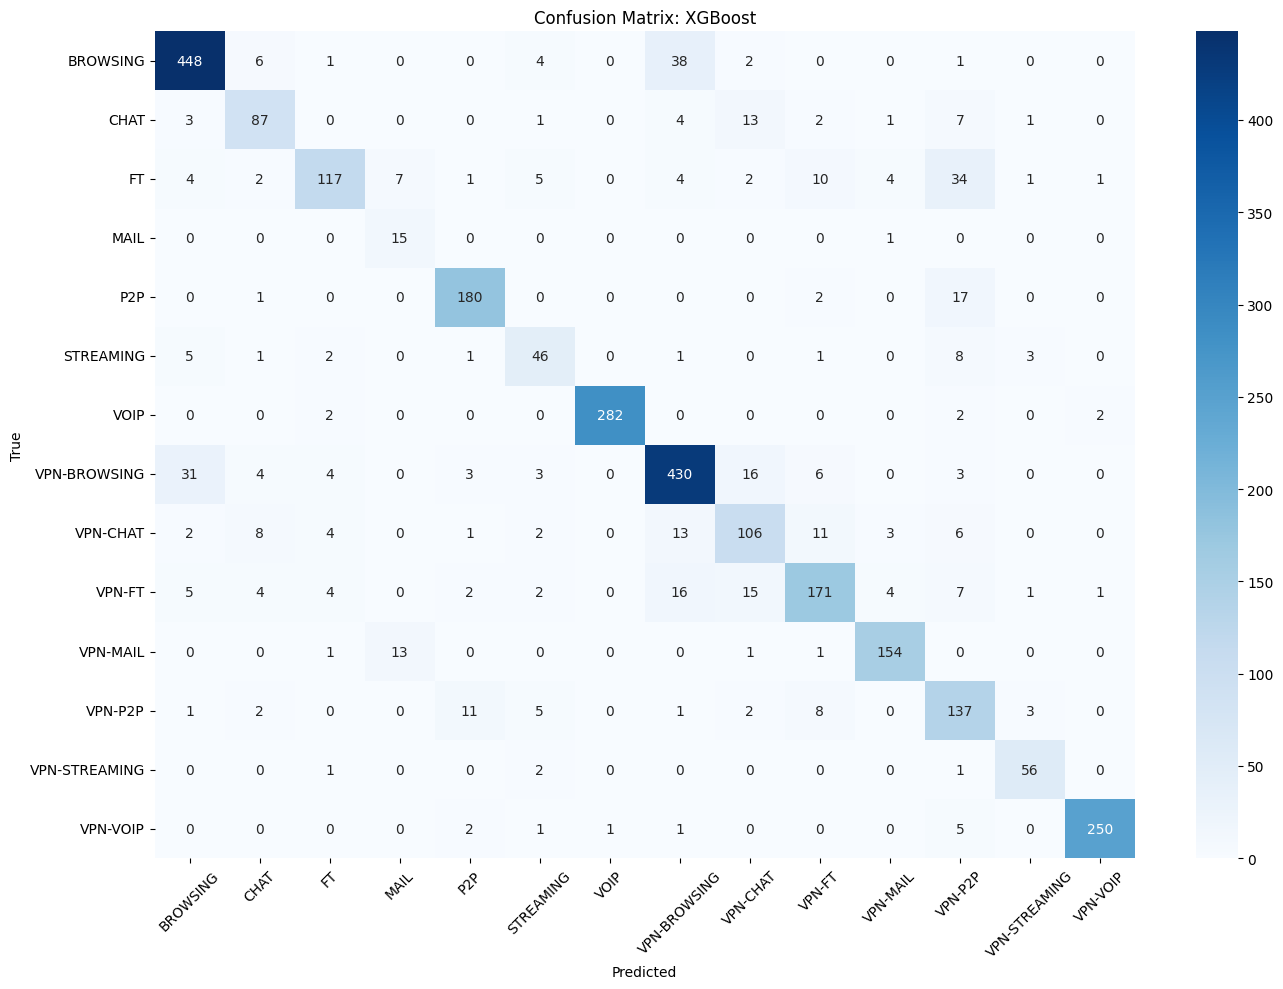

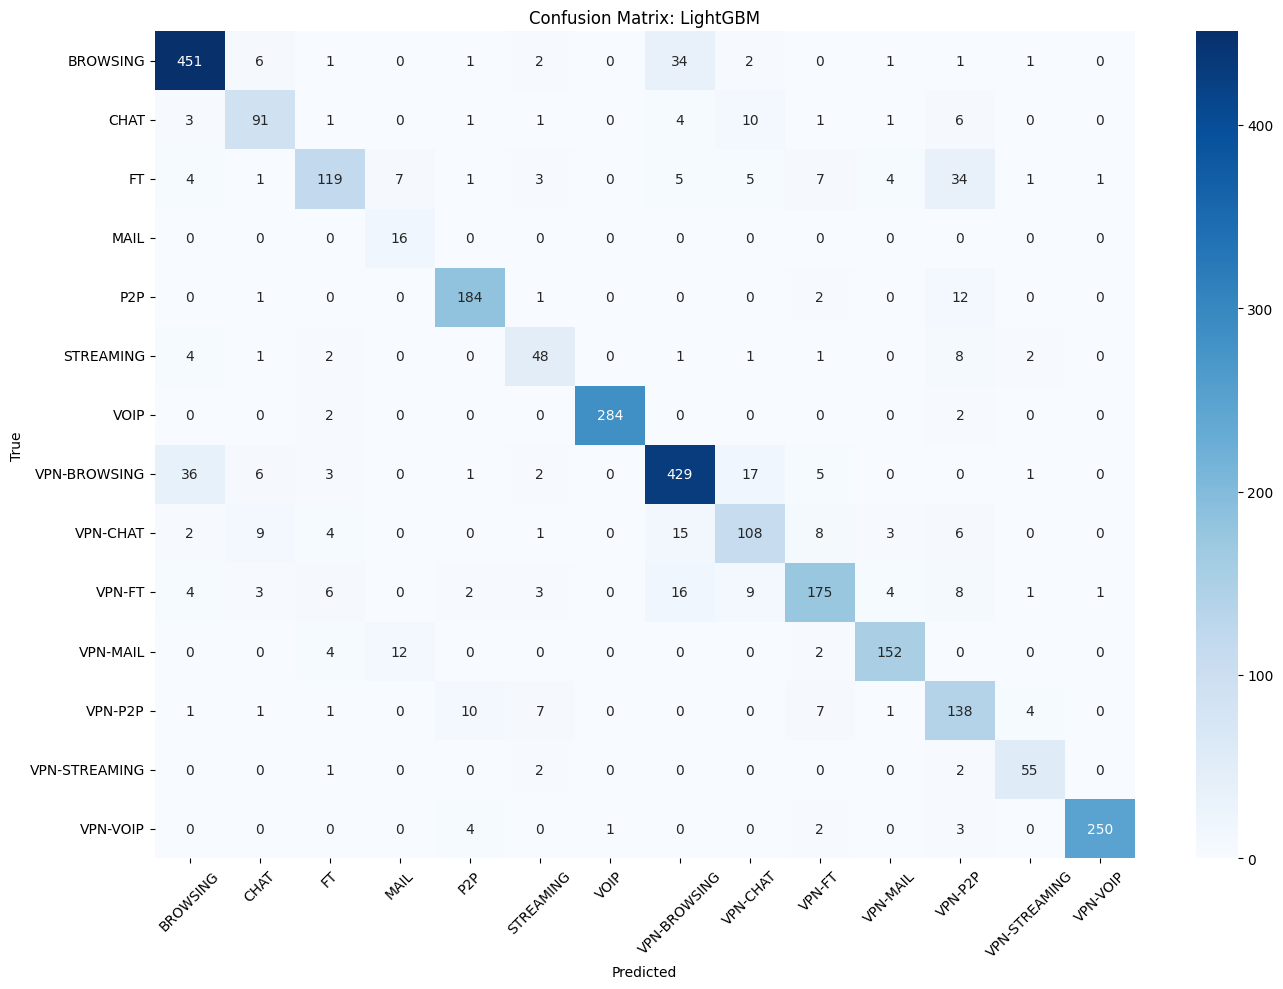

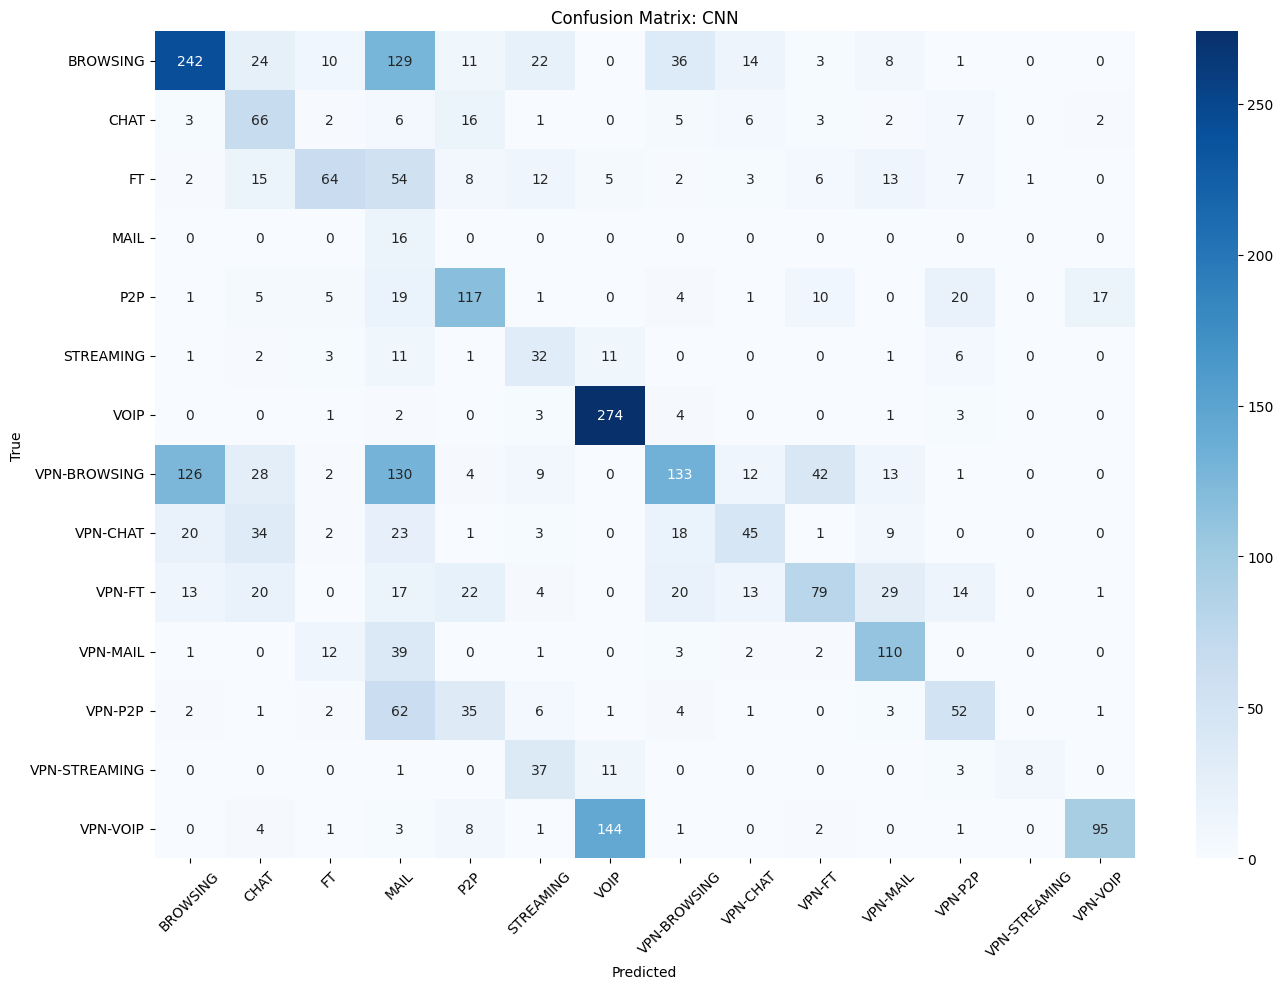

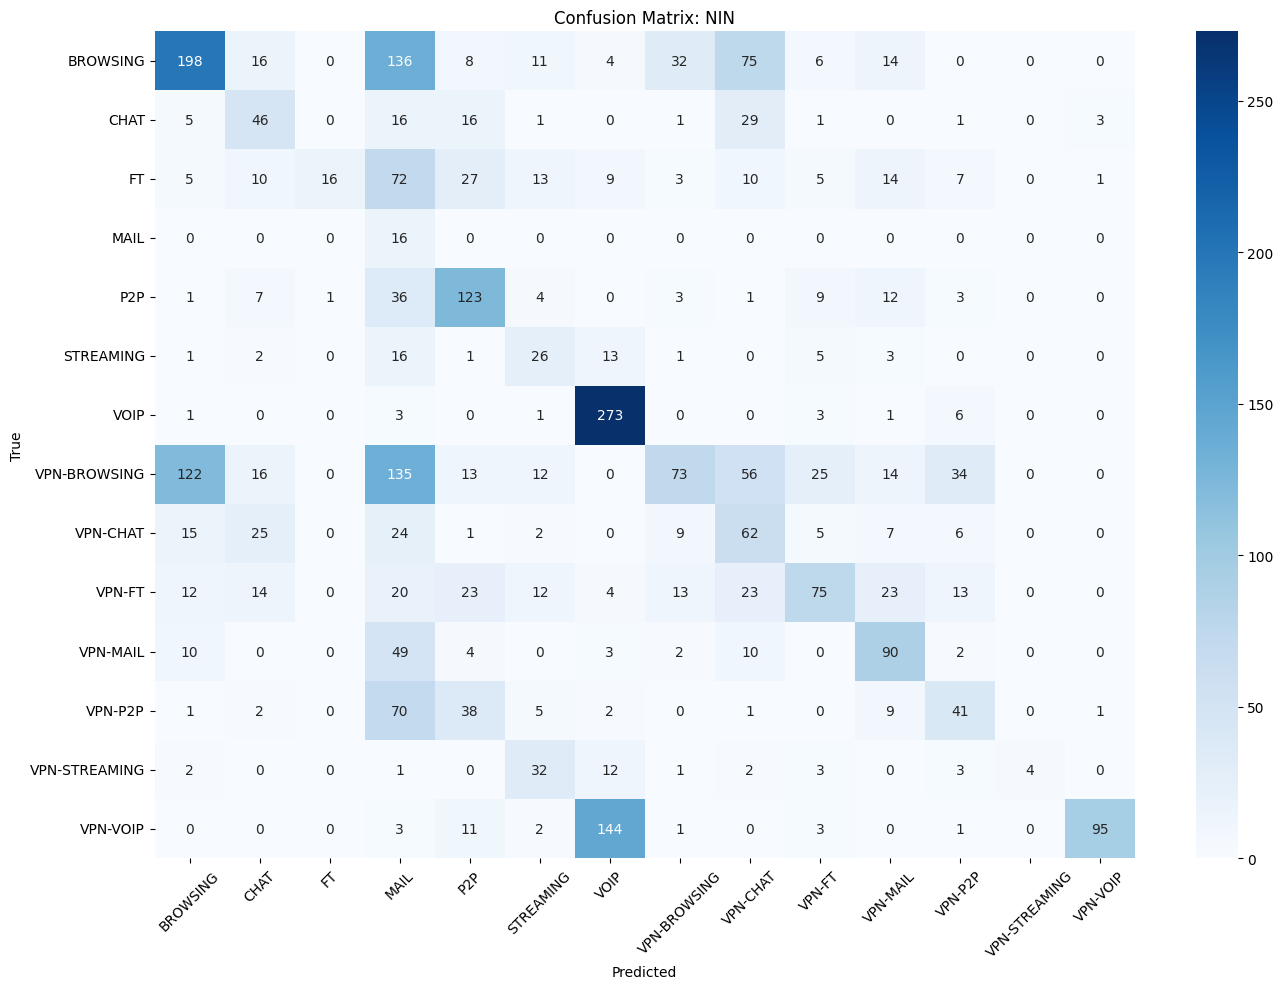

In [14]:
# === FINAL OPTIMIZED CODE FOR SCENARIO A (VPN + NON-VPN) ===

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Flatten, Dense, Dropout,
                                     BatchNormalization, GlobalAveragePooling1D, Input)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 1. LOAD & CLEAN DATA ===
df = pd.read_csv("scenario_a_combined.csv")
df.replace(-1, np.nan, inplace=True)
df.fillna(0, inplace=True)

# === 2. TRAIN-TEST SPLIT ===
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["class1"], random_state=42)
X_train = train_df.drop("class1", axis=1).values
y_train = train_df["class1"].values
X_test = test_df.drop("class1", axis=1).values
y_test = test_df["class1"].values

# === 3. LABEL ENCODING ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

# === 4. SCALING ===
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. SMOTE FOR IMBALANCED DATA ===
sm = SMOTE(random_state=42)
X_train_scaled, y_train_enc = sm.fit_resample(X_train_scaled, y_train_enc)

# === 6. RANDOM FOREST ===
rf = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight="balanced", random_state=42)
rf.fit(X_train_scaled, y_train_enc)
y_pred_rf = rf.predict(X_test_scaled)
print("\n\U0001F50D RF Accuracy:", accuracy_score(y_test_enc, y_pred_rf))
print("RF Classification Report:\n", classification_report(y_test_enc, y_pred_rf, target_names=le.classes_))
joblib.dump(rf, "rf_model.joblib")

# === 7. XGBOOST ===
xgb = XGBClassifier(device="cuda", tree_method="hist", objective="multi:softmax",
                    num_class=num_classes, n_estimators=150)
xgb.fit(X_train_scaled, y_train_enc)
y_pred_xgb = xgb.predict(X_test_scaled)
print("\n\U0001F50D XGBoost Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))
xgb.save_model("xgb_model.json")

# === 8. LIGHTGBM ===
lgbm = LGBMClassifier(n_estimators=150, num_leaves=31)
lgbm.fit(X_train_scaled, y_train_enc)
y_pred_lgbm = lgbm.predict(X_test_scaled)
print("\n\U0001F50D LightGBM Accuracy:", accuracy_score(y_test_enc, y_pred_lgbm))
print("LightGBM Classification Report:\n", classification_report(y_test_enc, y_pred_lgbm, target_names=le.classes_))

# === 9. CNN ===
X_train_cnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)
cnn = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(), MaxPooling1D(2), Dropout(0.3),
    Conv1D(128, 3, activation='relu'), BatchNormalization(),
    MaxPooling1D(2), Dropout(0.3), Flatten(),
    Dense(128, activation='relu'), Dropout(0.4),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_cnn, y_train_enc, epochs=30, batch_size=64, validation_split=0.1,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(patience=3)], verbose=1)
cnn_acc = cnn.evaluate(X_test_cnn, y_test_enc, verbose=0)[1]
y_pred_cnn = np.argmax(cnn.predict(X_test_cnn), axis=1)
print("\n\U0001F50D CNN Accuracy:", cnn_acc)
print("CNN Classification Report:\n", classification_report(y_test_enc, y_pred_cnn, target_names=le.classes_))
cnn.save("cnn_model.keras")

# === 10. NIN ===
inputs = Input(shape=(X_train_cnn.shape[1], 1))
x = Conv1D(64, 1, activation='relu')(inputs)
x = Conv1D(64, 3, padding='same', activation='relu')(x)
x = Conv1D(64, 5, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv1D(128, 1, activation='relu')(x)
x = Conv1D(128, 1, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(num_classes, activation='softmax')(x)
nin_model = Model(inputs=inputs, outputs=x)
nin_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nin_model.fit(X_train_cnn, y_train_enc, epochs=30, batch_size=64, validation_split=0.1,
              callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(patience=3)], verbose=1)
nin_acc = nin_model.evaluate(X_test_cnn, y_test_enc, verbose=0)[1]
y_pred_nin = np.argmax(nin_model.predict(X_test_cnn), axis=1)
print("\n\U0001F50D NIN Accuracy:", nin_acc)
print("NIN Classification Report:\n", classification_report(y_test_enc, y_pred_nin, target_names=le.classes_))
nin_model.save("nin_model.keras")

# === CONFUSION MATRIX PLOT ===
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_cm(y_test_enc, y_pred_rf, "Random Forest")
plot_cm(y_test_enc, y_pred_xgb, "XGBoost")
plot_cm(y_test_enc, y_pred_lgbm, "LightGBM")
plot_cm(y_test_enc, y_pred_cnn, "CNN")
plot_cm(y_test_enc, y_pred_nin, "NIN")
